In [1]:
import matplotlib.pyplot as plt
import numpy as np
import mbore
import tqdm.notebook
import os

In [2]:
%load_ext autoreload
%autoreload 2

In [7]:
# set up the things we need to load all optimisation runs
problem_names = ["DTLZ", "WFG", "RW", "WFG_HD"]
problem_names_to_paper = {
    "DTLZ": "DTLZ",
    "WFG": "WFG",
    "RW": "Real-world",
    "WFG_HD": "WFG (High-dimensional)"
}

final_results_dir = "final_results"

# note that these are the names used to run the code (not in the paper)
models = ["XGB", "FCNet", "GP"]

scalarizers = [
    "HypI",
    "DomRank",
    "HypCont", # known as 'PHC' in the paper
    "ParEGO", # known as 'AT' in the paper
]

# settings that we used for all problems
budget = 300
n_runs = 21

# mappings to ensure consistent labels across plots
model_to_paper = {"XGB": "XGB", "FCNet": "MLP", "GP": "GP"}

scalar_to_paper = {
    "HypI": "HYPI",
    "DomRank": "DOMRANK",
    "HypCont": "PHC",
    "ParEGO": "AT",
}

# colours and linestyles
model_colors = {
    "XGB": "tab:blue",
    "FCNet": "tab:orange",
    "GP": "tab:green",
}

scalar_to_ls = {
    "HypI": "-.", 
    "DomRank": "--", 
    "HypCont": "-",
    "ParEGO": ":"
}

scalar_conv_to_paper = {
    "HypI": "HYPI",
    "DomRank": "DR",
    "HypCont": "PHC",
    "ParEGO": "AT",
}

def plot_settings(ncols=1, nrows=1, fontsizebase=11, usetex=True):
    from tueplots import  axes, fontsizes

    base_width = 3.25
    base_height = 2.0

    settings = {
        'text.usetex': usetex, # needs to be turned on for final paper!
        'font.family': 'serif',
        'text.latex.preamble': ''.join([
            r"\usepackage{libertine}",
            r"\usepackage[libertine]{newtxmath}",
        ]),
        # 'font.serif': ['Linux Libertine'],
        # 'font.family': 'serif',
        # 'mathtext.fontset': 'custom',
        # 'mathtext.rm': 'Linux Libertine',
        # 'mathtext.it': 'Linux Libertine:italic',
        # 'mathtext.bf': 'Linux Libertine:bold',
        'pdf.fonttype': 42,
        'ps.fonttype': 42,

        'figure.constrained_layout.use': True,
        'figure.autolayout': False,
        "hatch.linewidth" : 0.5,
        "figure.figsize": (base_width * ncols, base_height * nrows ),
    }
    settings.update(fontsizes._from_base(base=fontsizebase))
    settings.update(axes.lines())

    return settings

def gs_compress(path):
    import subprocess
    import shutil
    import os
    
    # copy file to temp
    tempname = "temp1.pdf"
    final_name = "final.pdf"
    shutil.copyfile(path, tempname)
    
    cmd = [
        r"gswin64.exe",
        "-sDEVICE=pdfwrite",
        "-dSubsetFonts=true",
        "-dPDFSETTINGS=/prepress",
        "-dCompressFonts=true",
        "-dNOPAUSE",
        "-dBATCH",
        f'-sOutputFile={final_name}',
        f'{tempname}'
    ]

    try:
        subprocess.run(' '.join(cmd))

        # rename final
        shutil.move(final_name, path)
        os.remove(tempname)
    except:
        print('Ghostscript not installed (or not on Windows), skipping pdf compression')
        pass


#### Plots showing which scalarisation is the best overall (for a given problem set)

In [8]:
for original_problem_name in tqdm.notebook.tqdm(problem_names):

    savename = f"{original_problem_name:s}_statstests.npz"
    savepath = os.path.join(final_results_dir, savename)

    with np.load(savepath, allow_pickle=True) as fd:
        assert original_problem_name == fd["original_problem_name"]
        
        # per-scalariser results
        # td[indicator][scalarizer][problem_id][dim][fdim]
        td = fd["td"].item()

        # results for each combo of (scalarizer, model)
        # tds[indicator][problem_id][dim][fdim]
        tds = fd["tds"].item()

    problem_name, prob_dict = mbore.problem_sets.get_problem_dict(
        original_problem_name
    )
    total_problems = mbore.problem_sets.get_number_of_problems(prob_dict)
    print(f"Problem set: {problem_name:s}. {total_problems:d} total problems")

    # gather up the keys for this list
    n_scalarizers_and_models = len(scalarizers) * len(models)

    scalarizers_and_model_combos = [
        (scalarizer, model)
        for scalarizer in scalarizers
        for model in models
    ]

    for indicator in ["hv", "igd+"]:
        yv = []
        labels = []
        bar_colors = []

        for i, (scalar, model) in enumerate(scalarizers_and_model_combos):
            yv.append(i)

            scal_print_name = scalar_to_paper[scalar]
            m_print_name = model_to_paper[model]

            labels.append(f"{m_print_name:s} + {scal_print_name:s}")
            bar_colors.append(model_colors[model])

        counts = np.zeros(len(scalarizers_and_model_combos))

        for problem_id in prob_dict:
            for dim, fdims in prob_dict[problem_id]:
                for fdim in fdims:
                    counts += tds[indicator][problem_id][dim][fdim]["best_mask"]

        counts /= total_problems

        #title = f"Test problems: {problem_name}. Indicator: {indicator[:3]}"
        #title = "Proportion of times each combination is best"
        title = f"{indicator.upper():s}"
        title += f" Performance Summary:"
        title += f" {problem_names_to_paper[original_problem_name]}"

        xlabel = "Scalarisation method"

        with plt.rc_context(plot_settings(ncols=1, nrows=0.65, fontsizebase=10)):

            n = len(scalarizers)
            m = len(models)
            
            width = 0.2

            fig, ax = plt.subplots()

            for i in range(n):
                xv = np.array([-0.21, 0, 0.21]) + i
                widths = counts[m * i: (i+1)*m]

                ax.bar(
                    x=xv, 
                    height=widths,
                    width=width,
                    color=[model_colors[m] for m in models]
                )

            # # show the split line to make the grounpings even *more* obvious
            # for i in range(n-1):
            #     ax.axvline(i + 0.5, c='k', alpha=0.2, ls='--')
            
            ax.set_xticks(np.arange(n))
            ax.set_xticklabels(
                [scalar_to_paper[s] for s in scalarizers], 
                rotation=0)
            ax.set_ylim([0, 1])

            # create legend
            for m in models:
                ax.plot(0, 0, label=model_to_paper[m], color=model_colors[m], lw=5)
            
            ax.legend(
                loc="upper left", 
                ncol=len(models),
                handletextpad=0.5, # distance between colour and text
                columnspacing=1, # spacing between columns (labels)
                borderaxespad=0.05, # spacing from the edge of the plot
                frameon=False,
            )

            ax.set_title(title)
            # ax.set_xlabel(xlabel)
            fname = f'{indicator:s}_{original_problem_name:s}_summary_barchart.pdf'
            plt.savefig(fname)
            plt.close()
            plt.show()

            gs_compress(fname)

  0%|          | 0/4 [00:00<?, ?it/s]

Problem set: DTLZ. 56 total problems
Problem set: WFG. 63 total problems
Problem set: RW. 10 total problems
Problem set: WFG. 27 total problems


### Plots showing which *model* (XGB/MLP/GP) is best by dimensionality and objective, PER SCALARISER

In [9]:
box_dim_data = {}

for original_problem_name in problem_names:
    if original_problem_name == "RW":
        continue

    savename = f"{original_problem_name:s}_statstests.npz"
    savepath = os.path.join(final_results_dir, savename)

    with np.load(savepath, allow_pickle=True) as fd:
        assert original_problem_name == fd["original_problem_name"]
        
        # per-scalariser results
        # td[indicator][scalarizer][problem_id][dim][fdim]
        td = fd["td"].item()

        # results for each combo of (scalarizer, model)
        # tds[indicator][problem_id][dim][fdim]
        tds = fd["tds"].item()

    problem_name, prob_dict = mbore.problem_sets.get_problem_dict(
        original_problem_name
    )
    total_problems = mbore.problem_sets.get_number_of_problems(prob_dict)

    # get all the function dimensions used
    dims = np.sort(
        np.unique(
            [
                dim
                for problem_id in prob_dict
                for dim, _ in prob_dict[problem_id]
            ]
        )
    )

    for indicator in ["hv", "igd+"]:

        n_methods = len(models)

        for scalarizer in scalarizers:
            exp_counts = {dim: 0 for dim in dims}
            box_data = {dim: np.zeros(n_methods) for dim in dims}

            for problem_id in prob_dict:
                for dim, fdims in prob_dict[problem_id]:
                    for fdim in fdims:

                        box_data[dim] += td[indicator][scalarizer][problem_id][
                            dim
                        ][fdim]["best_mask"]
                        exp_counts[dim] += 1

            # normalise boxplot data
            for dim in dims:
                box_data[dim] /= exp_counts[dim]

            key = (original_problem_name, indicator, scalarizer)

            box_dim_data[key] = box_data

for (
    original_problem_name, 
    indicator, 
    scalarizer
), box_data in box_dim_data.items():

    problem_name, prob_dict = mbore.problem_sets.get_problem_dict(
        original_problem_name
    )
    n_methods = len(models)
    
    with plt.rc_context(plot_settings(ncols=1, nrows=0.8, fontsizebase=10)):

        offset_increment = 2
        xv = np.linspace(0, 1 - 1 / n_methods, n_methods)
        widths = 0.95 * (1 / n_methods)
        labels = list(box_data.keys())

        fig, ax = plt.subplots()
        for offset_idx, key in enumerate(box_data):
            bars = ax.bar(
                x=xv + (offset_increment * offset_idx),
                height=box_data[key],
                width=widths,
                color=[model_colors[m] for m in models],
            )

        ax.set_ylim([0, 1])

        # set up the bar labels
        xx = np.arange(0.325, len(labels) * offset_increment, offset_increment)
        ax.set_xticks(xx)
        ax.set_xticklabels(labels)
        ax.set_title(
            f"{problem_name:s}: {scalar_to_paper[scalarizer]:s}"
        )

        ax.set_xlabel('Problem dimensionality')

        # create legend
        for m in models:
            ax.plot(0, 0, label=model_to_paper[m], color=model_colors[m], lw=5)
        
        ax.legend(
            loc="upper left", 
            ncol=len(models),
            handletextpad=0.5, # distance between colour and text
            columnspacing=1, # spacing between columns (labels)
            borderaxespad=0.05, # spacing from the edge of the plot
            frameon=False,
        )

        ax.xaxis.set_label_coords(0.5, -0.15)

        fname = f"{indicator:s}_{original_problem_name:s}_dim_{scalarizer}.pdf"
        print(fname)
        plt.savefig(fname)
        plt.close()
        plt.show()

        gs_compress(fname)

hv_DTLZ_dim_HypI.pdf
hv_DTLZ_dim_DomRank.pdf
hv_DTLZ_dim_HypCont.pdf
hv_DTLZ_dim_ParEGO.pdf
igd+_DTLZ_dim_HypI.pdf
igd+_DTLZ_dim_DomRank.pdf
igd+_DTLZ_dim_HypCont.pdf
igd+_DTLZ_dim_ParEGO.pdf
hv_WFG_dim_HypI.pdf
hv_WFG_dim_DomRank.pdf
hv_WFG_dim_HypCont.pdf
hv_WFG_dim_ParEGO.pdf
igd+_WFG_dim_HypI.pdf
igd+_WFG_dim_DomRank.pdf
igd+_WFG_dim_HypCont.pdf
igd+_WFG_dim_ParEGO.pdf
hv_WFG_HD_dim_HypI.pdf
hv_WFG_HD_dim_DomRank.pdf
hv_WFG_HD_dim_HypCont.pdf
hv_WFG_HD_dim_ParEGO.pdf
igd+_WFG_HD_dim_HypI.pdf
igd+_WFG_HD_dim_DomRank.pdf
igd+_WFG_HD_dim_HypCont.pdf
igd+_WFG_HD_dim_ParEGO.pdf


In [10]:
box_obj_data = {}

for original_problem_name in problem_names:
    if original_problem_name == "RW":
        continue

    savename = f"{original_problem_name:s}_statstests.npz"
    savepath = os.path.join(final_results_dir, savename)

    with np.load(savepath, allow_pickle=True) as fd:
        assert original_problem_name == fd["original_problem_name"]
        
        # per-scalariser results
        # td[indicator][scalarizer][problem_id][dim][fdim]
        td = fd["td"].item()

        # results for each combo of (scalarizer, model)
        # tds[indicator][problem_id][dim][fdim]
        tds = fd["tds"].item()

    problem_name, prob_dict = mbore.problem_sets.get_problem_dict(
        original_problem_name
    )
    total_problems = mbore.problem_sets.get_number_of_problems(prob_dict)

    fdims = np.sort(
        np.unique(
            [
                fdim
                for problem_id in prob_dict
                for _, fdims in prob_dict[problem_id]
                for fdim in fdims
            ]
        )
    )
    n_fdims = fdims.size
    n_models = len(models)

    for indicator in ["hv", "igd+"]:


        for scalarizer in scalarizers:

            box_data = {fdim: np.zeros(n_models) for fdim in fdims}
            exp_counts = {fdim: 0 for fdim in fdims}

            for problem_id in prob_dict:
                for dim, fdims in prob_dict[problem_id]:
                    for fdim in fdims:

                        box_data[fdim] += td[indicator][scalarizer][problem_id][
                            dim
                        ][fdim]["best_mask"]
                        exp_counts[fdim] += 1

            # normalise boxplot data
            for fdim in box_data:
                box_data[fdim] /= exp_counts[fdim]

            key = (original_problem_name, indicator, scalarizer)
            box_obj_data[key] = box_data

for (
    original_problem_name, 
    indicator, 
    scalarizer
), box_data in box_obj_data.items():

    problem_name, prob_dict = mbore.problem_sets.get_problem_dict(
        original_problem_name
    )
    n_methods = len(models)

    with plt.rc_context(plot_settings(ncols=1, nrows=0.8, fontsizebase=10)):

        offset_increment = 1.5
        xv = np.linspace(0, 1 - 1 / n_methods, n_methods)
        widths = 0.9 * (1 / n_methods)
        labels = list(box_data.keys())

        fig, ax = plt.subplots()
        for offset_idx, key in enumerate(box_data):
            bars = ax.bar(
                x=xv + (offset_increment * offset_idx),
                height=box_data[key],
                width=widths,
                color=[model_colors[m] for m in models],
            )

        ax.set_ylim([0, 1])

        # set up the bar labels
        xx = np.arange(0.325, len(labels) * offset_increment, offset_increment)
        ax.set_xticks(xx)
        ax.set_xticklabels(labels)
        ax.set_title(
            f"{problem_name:s}: {scalar_to_paper[scalarizer]:s}"
        )

        ax.set_xlabel('Number of objectives')

        # create legend
        for m in models:
            ax.plot(0, 0, label=model_to_paper[m], color=model_colors[m], lw=5)
        
        ax.legend(
            loc="upper left", 
            ncol=len(models),
            handletextpad=0.5, # distance between colour and text
            columnspacing=1, # spacing between columns (labels)
            borderaxespad=0.05, # spacing from the edge of the plot
            frameon=False,
        )

        ax.xaxis.set_label_coords(0.5, -0.20)

        fname = f"{indicator:s}_{original_problem_name:s}_obj_{scalarizer}.pdf"
        print(fname)
        plt.savefig(fname)
        plt.close()
        plt.show()

        gs_compress(fname)

hv_DTLZ_obj_HypI.pdf
hv_DTLZ_obj_DomRank.pdf
hv_DTLZ_obj_HypCont.pdf
hv_DTLZ_obj_ParEGO.pdf
igd+_DTLZ_obj_HypI.pdf
igd+_DTLZ_obj_DomRank.pdf
igd+_DTLZ_obj_HypCont.pdf
igd+_DTLZ_obj_ParEGO.pdf
hv_WFG_obj_HypI.pdf
hv_WFG_obj_DomRank.pdf
hv_WFG_obj_HypCont.pdf
hv_WFG_obj_ParEGO.pdf
igd+_WFG_obj_HypI.pdf
igd+_WFG_obj_DomRank.pdf
igd+_WFG_obj_HypCont.pdf
igd+_WFG_obj_ParEGO.pdf
hv_WFG_HD_obj_HypI.pdf
hv_WFG_HD_obj_DomRank.pdf
hv_WFG_HD_obj_HypCont.pdf
hv_WFG_HD_obj_ParEGO.pdf
igd+_WFG_HD_obj_HypI.pdf
igd+_WFG_HD_obj_DomRank.pdf
igd+_WFG_HD_obj_HypCont.pdf
igd+_WFG_HD_obj_ParEGO.pdf


### Timing plots per problem dimensionality (skipping RW problems)

In [19]:
start_from_idx = 1
step = 2

for original_problem_name in tqdm.notebook.tqdm(problem_names):

    if original_problem_name == "RW":
        print("Skipping real-world problems")
        continue

    savename = f"{original_problem_name:s}.npz"
    savepath = os.path.join(final_results_dir, savename)

    with np.load(savepath, allow_pickle=True) as fd:
        assert original_problem_name == fd["original_problem_name"]

        D = fd['D'].item()

    problem_name, prob_dict = mbore.problem_sets.get_problem_dict(
        original_problem_name
    )
    total_problems = mbore.problem_sets.get_number_of_problems(prob_dict)
    print(f"Problem set: {problem_name:s}. {total_problems:d} total problems")

    data = {model: {} for model in models}

    for i, model in enumerate(models):
        for scalarizer in scalarizers:
            for problem_id in prob_dict:
                for dim, fdims in prob_dict[problem_id]:
                    if dim not in data[model]:
                        data[model][dim] = []

                    for fdim in fdims:

                        Z = D[problem_id][dim][fdim][scalarizer][model]['timing']

                        data[model][dim].append(Z)

    dims = np.sort(
        np.unique(
            [
                dim
                for problem_id in prob_dict
                for dim, fdims in prob_dict[problem_id]
            ]
        )
    )

    for dim in dims:

        x = np.arange(start_from_idx, budget)

        with plt.rc_context(plot_settings(ncols=1, nrows=0.8, fontsizebase=10)):
            fig, ax = plt.subplots()

            for model in data:
                Z = np.concatenate(data[model][dim])[:, start_from_idx:]
                c = model_colors[model]

                low, mid, high = np.percentile(Z, q=[25, 50, 75], axis=0)

                ax.plot(x[::step], mid[::step], c=c, alpha=1)
                ax.fill_between(x[::step], low[::step], high[::step], alpha=0.2, color=c)

            title = f"Computation time: {problem_name} ($d = {dim}$)" 
            ax.set_title(title)
            
            ax.set_xlim([0, budget])
            ax.set_ylim([0, ax.get_ylim()[1]])
            ax.set_ylabel("Time (seconds)")
            ax.set_xlabel("Iteration")

            ax.yaxis.set_label_coords(-0.1, 0.5)
            ax.xaxis.set_label_coords(0.5, -0.17)

            ticklabels = ax.get_xticklabels()
            ticklabels[0].set_ha("left")
            ticklabels[-1].set_ha("right")

            # create legend
            for m in models:
                ax.plot(0, 0, label=model_to_paper[m], color=model_colors[m], lw=5)
            
            ax.legend(
                loc="upper left",
                ncol=len(models),
                handletextpad=0.5, # distance between colour and text
                columnspacing=1, # spacing between columns (labels)
                borderaxespad=0.05, # spacing from the edge of the plot
                frameon=False,
            )

            fname = f"{original_problem_name:s}_timing_d={dim:d}.pdf"
            plt.savefig(fname)
            plt.close()
            plt.show()

            gs_compress(fname)

  0%|          | 0/4 [00:00<?, ?it/s]

Problem set: DTLZ. 56 total problems
Problem set: WFG. 63 total problems
Skipping real-world problems
Problem set: WFG. 27 total problems


### Which model is better for a given scalarisation method? (Table data)

In [12]:
for original_problem_name in tqdm.notebook.tqdm(problem_names):
    savename = f"{original_problem_name:s}_statstests.npz"
    savepath = os.path.join(final_results_dir, savename)

    with np.load(savepath, allow_pickle=True) as fd:
        assert original_problem_name == fd["original_problem_name"]
        
        # per-scalariser results
        # td[indicator][scalarizer][problem_id][dim][fdim]
        td = fd["td"].item()

        # results for each combo of (scalarizer, model)
        # tds[indicator][problem_id][dim][fdim]
        tds = fd["tds"].item()

    problem_name, prob_dict = mbore.problem_sets.get_problem_dict(
        original_problem_name
    )
    total_problems = mbore.problem_sets.get_number_of_problems(prob_dict)
    # print(f"Problem set: {problem_name:s}. {total_problems:d} total problems")

    for scalarizer in scalarizers:

        for indicator in ['hv', 'igd+']:

            n_models = len(models)

            overall_bests = np.zeros(n_models, dtype='int')
            c = 0

            for problem_id in prob_dict:
                for dim, fdims in prob_dict[problem_id]:
                    for fdim in fdims:

                        overall_bests += td[indicator][scalarizer][problem_id][
                            dim
                        ][fdim]["best_mask"]
                        c += 1

            print(original_problem_name, scalarizer, overall_bests)


  0%|          | 0/4 [00:00<?, ?it/s]

DTLZ HypI [36  4 29]
DTLZ HypI [40  1 28]
DTLZ DomRank [21 11 37]
DTLZ DomRank [30  5 36]
DTLZ HypCont [36 12 22]
DTLZ HypCont [41  8 22]
DTLZ ParEGO [13  8 43]
DTLZ ParEGO [27  2 42]
WFG HypI [37  0 36]
WFG HypI [36  1 34]
WFG DomRank [36  0 45]
WFG DomRank [40  1 35]
WFG HypCont [39  0 36]
WFG HypCont [38  0 35]
WFG ParEGO [ 1  0 63]
WFG ParEGO [ 4  2 62]
RW HypI [4 0 6]
RW HypI [5 0 6]
RW DomRank [1 1 8]
RW DomRank [2 1 8]
RW HypCont [7 0 5]
RW HypCont [9 0 3]
RW ParEGO [2 0 8]
RW ParEGO [2 0 8]
WFG_HD HypI [10  7 18]
WFG_HD HypI [10  9 18]
WFG_HD DomRank [ 5 15 17]
WFG_HD DomRank [ 7 16 10]
WFG_HD HypCont [18  6  7]
WFG_HD HypCont [17  5  6]
WFG_HD ParEGO [ 0  4 23]
WFG_HD ParEGO [ 0  8 23]


## Combined HV plot for PHC on DTLZ and WFG

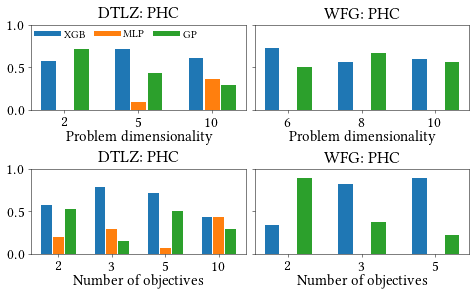

In [13]:
combos = [
    ('DTLZ', 'hv', 'HypCont'),
    ('WFG', 'hv', 'HypCont')
]

n_models = len(models)

settings = plot_settings(ncols=2, nrows=2, fontsizebase=18)
settings['axes.labelsize'] -= 2
settings['legend.fontsize'] -= 4

with plt.rc_context(settings):
    fig, axes = plt.subplots(2, 2, sharey=True)

    for i, boxes in enumerate([box_dim_data, box_obj_data]):
        for j, key in enumerate(combos):
            ax = axes[i, j]

            original_problem_name, indicator, scalarizer = key
            box_data = boxes[key]
            problem_name, _ = mbore.problem_sets.get_problem_dict(
                original_problem_name
            )

            offset_increment = 1.5
            xv = np.linspace(0, 1 - 1 / n_models, n_models)
            widths = 0.9 * (1 / n_models)
            labels = list(box_data.keys())

            for offset_idx, key in enumerate(box_data):
                bars = ax.bar(
                    x=xv + (offset_increment * offset_idx),
                    height=box_data[key],
                    width=widths,
                    color=[model_colors[m] for m in models],
                )

            # set up the bar labels
            xx = np.arange(0.325, len(labels) * offset_increment, offset_increment)
            ax.set_xticks(xx)
            ax.set_xticklabels(labels)
            ax.set_title(
                f"{problem_name:s}: {scalar_to_paper[scalarizer]:s}"
            )

            if i == 1:
                ax.set_xlabel('Number of objectives')
            else:
                ax.set_xlabel('Problem dimensionality')
            ax.xaxis.set_label_coords(0.5, -0.25)

    # create legend
    for m in models:
        axes[0, 0].plot(0, 0, label=model_to_paper[m], color=model_colors[m], lw=5)
    
    axes[0, 0].legend(
        loc="upper left",
        ncol=len(models),
        handletextpad=0.5, # distance between colour and text
        columnspacing=1, # spacing between columns (labels)
        borderaxespad=0.05, # spacing from the edge of the plot
        frameon=False,
    )


    axes[0, 0].set_ylim([0, 1])
    fname = 'dtlz_wfg_combined.pdf'
    plt.savefig(fname)
    plt.show()

    gs_compress(fname)

### Combined timing plot for paper

In [14]:
# problem, dim, n_obj
timing_plot_things = [
    ("WFG", 10),
    ("WFG_HD", 20),
    ("WFG_HD", 50),
    ("WFG_HD", 100),
]


timing_data = {
    dim: {model:[] for model in models} 
    for (_, dim)  in timing_plot_things
}

for (original_problem_name, use_dim) in timing_plot_things:
    savename = f"{original_problem_name:s}.npz"
    savepath = os.path.join(final_results_dir, savename)

    with np.load(savepath, allow_pickle=True) as fd:
        D = fd['D'].item()

    problem_name, prob_dict = mbore.problem_sets.get_problem_dict(
        original_problem_name
    )

    for model in models:
        for scalarizer in scalarizers:
            for problem_id in prob_dict:
                for dim, fdims in prob_dict[problem_id]:
                    if dim != use_dim:
                        continue

                    for fdim in fdims:
                        Z = D[problem_id][dim][fdim][scalarizer][model]['timing']
                        timing_data[dim][model].append(Z)


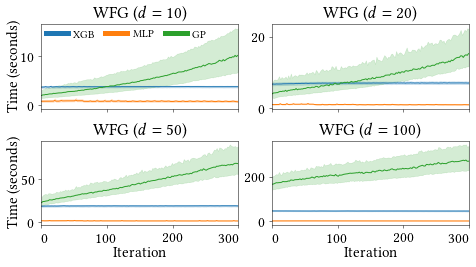

In [18]:
start_from_idx = 1
step = 2

x = np.arange(start_from_idx, budget)

settings = plot_settings(ncols=2, nrows=1.8, fontsizebase=18)
settings['axes.labelsize'] -= 2
settings['legend.fontsize'] -= 4

with plt.rc_context(settings):
    fig, axes = plt.subplots(2, 2, sharey=False, sharex=True)

    for i, dim in enumerate(timing_data):
        ax = axes.flat[i]
        
        for model in timing_data[dim]:
            Z = np.concatenate(timing_data[dim][model])[:, start_from_idx:]
            c = model_colors[model]

            low, mid, high = np.percentile(Z, q=[25, 50, 75], axis=0)

            ax.plot(x[::step], mid[::step], c=c, alpha=1)
            ax.fill_between(x[::step], low[::step], high[::step], alpha=0.2, color=c)

        title = f"WFG ($d = {dim}$)"
        ax.set_title(title)

    axes[0, 0].set_xlim([0, budget])

    for i in range(2):
        axes[1, i].set_xlabel('Iteration')
        axes[1, i].xaxis.set_label_coords(0.5, -0.25)

        ticklabels = axes[1, i].get_xticklabels()
        ticklabels[0].set_ha("left")
        ticklabels[-1].set_ha("right")
        
        axes[i, 0].set_ylabel('Time (seconds)')
        axes[i, 0].yaxis.set_label_coords(-0.1, 0.5)

    # create legend
    for m in models:
        axes[0, 0].plot(0, 0, label=model_to_paper[m], color=model_colors[m], lw=5)
    
    axes[0, 0].legend(
        loc="upper left",
        ncol=len(models),
        handletextpad=0.5, # distance between colour and text
        columnspacing=1, # spacing between columns (labels)
        borderaxespad=0.05, # spacing from the edge of the plot
        frameon=False,
    )
    

    fname = 'timing_combined.pdf'
    plt.savefig(fname)
    plt.show()

    gs_compress(fname)

### Convergence plots

In [24]:
from matplotlib.ticker import StrMethodFormatter

rw_id_to_name = {
    21: "RE2-4-1",
    24: "RE2-2-4",
    31: "RE3-3-1",
    32: "RE3-4-2",
    34: "RE3-5-4",
    37: "RE3-4-7",
    41: "RE4-7-1",
    42: "RE4-6-2",
    61: "RE6-3-1",
    91: "RE9-7-1",
}

settings = plot_settings(ncols=1, nrows=1, fontsizebase=10)
settings['legend.fontsize'] -= 2

step = 2

x = np.arange(budget + 1)

for original_problem_name in problem_names:
    if original_problem_name != "WFG_HD":
        continue

    savename = f"{original_problem_name:s}.npz"
    savepath = os.path.join(final_results_dir, savename)

    with np.load(savepath, allow_pickle=True) as fd:
        D = fd['D'].item()

    problem_name, prob_dict = mbore.problem_sets.get_problem_dict(
        original_problem_name
    )

    total = mbore.problem_sets.get_number_of_problems(prob_dict) * 2

    pbar = tqdm.notebook.tqdm(total=total)

    for problem_id in prob_dict:
        for dim, fdims in prob_dict[problem_id]:
            for fdim in fdims:
                for indicator in ['hv', 'igd+']:
                    with plt.rc_context(settings):
                        fig, ax = plt.subplots(1, 1)

                        for scalarizer in scalarizers:
                            ls = scalar_to_ls[scalarizer]
                            s_paper_name = scalar_conv_to_paper[scalarizer]

                            for model in D[problem_id][dim][fdim][scalarizer]:
                                c = model_colors[model]

                                paper_model_name = model_to_paper[model]

                                label = f"{paper_model_name} + {s_paper_name}"

                                Z = D[problem_id][dim][fdim][scalarizer][model][indicator]

                                lower, mid, upper = np.percentile(Z, [25, 50, 75], axis=0)

                                ax.fill_between(
                                    x[::step], lower[::step], upper[::step], 
                                    alpha=0.2, color=c, rasterized=False,
                                )
                                ax.plot(x[::step], mid[::step], label=label, color=c, linestyle=ls)
                                
                        if problem_name == "RW":
                            pn = f"{rw_id_to_name[problem_id]}"
                        else:
                            pn = f"{problem_name:s}{problem_id:d}"
                        
                        name = f"{indicator.upper()}: {pn} ($d={dim:d}, M={fdim:d}$)"
                        ax.set_title(name)
                        
                        ax.set_xlim([0, budget])
                        
                        ax.legend(
                            loc='lower right' if indicator == 'hv' else 'upper right',
                            ncol=4,
                            handletextpad=0.5,
                            columnspacing=1,
                            borderaxespad=0.05,
                            frameon=True,
                        )
                        
                        plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}'))
                        
                        fname = f"conv_{indicator}_{problem_name}{problem_id}_{dim}_{fdim}.pdf"

                        plt.savefig(fname)
                        plt.close()
                        plt.show()
                        pbar.update()
    pbar.close()
print("Don't forget to compress these afterwards!")

  0%|          | 0/54 [00:00<?, ?it/s]

Don't forget to compress these afterwards!


In [25]:
import glob
files = glob.glob("*.pdf")

for fname in tqdm.notebook.tqdm(files):
    gs_compress(fname)

  0%|          | 0/54 [00:00<?, ?it/s]